# Testando os resultados das três buscas em grade com os 20 e 15 atributos selecionados utilizando a correlação de Pearson

**Busca em grade 1:**
- Paciência: $25$ e $50$
- batch_size: $16$ e $32$
- $\beta_1$: $1$, $0.9$, $0.8$ 
- $\beta_2$: $0.999$, $0.95$, $0.9$
- Épocas: $300$ e $500$
- Função de ativação: $relu, sigmoide$
- Quantidade de atributos considerados: $20$

**Busca em grade 2:**
- Paciência: $100$ e $50$
- batch_size: $16$ e $32$
- $\beta_1$: $1$, $0.9$, $0.8$, $0.95$
- $\beta_2$: $0.999$, $0.95$, $0.9$
- Épocas: $500$ e $700$
- Função de ativação: $relu$
- Quantidade de atributos considerados: $20$

**Busca em grade 3:**
- Paciência: $100$ e $50$
- batch_size: $16$ e $32$
- $\beta_1$: $1$, $0.9$, $0.8$ , $0.95$
- $\beta_2$: $0.999$, $0.95$, $0.9$
- Épocas: $500$ e $700$
- Função de ativação: $relu$
- Quantidade de atributos considerados: $15$

***Obs:*** *Observamos que todos os resultados utilizando sigmoide apresentaram um desempenho extremamente baixo para prever quando o paciente realmente possui a síndrome dos ovários policístico. Por isso, nos resultados da busca em grade em que aparece "logistic", mudamos para "relu"*

In [1]:
import pandas as pd
import numpy as np
from utilities.show_results import plot_confusion_matrix, get_accuracy, get_precision
from utilities.pearson_correlation import choose_with_pearson
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from joblib import dump, load

## Carregando os datasets

Abrindo:
1. grid_1: Resultados da busca em grade utilizando os 20 atributos considerando a função de ativação sigmoide na busca
2. grid_2: Resultados da busca em grade utilizando os 20 atributos sem considerar a função de ativação sigmoide na busca
3. grid_3: Resultados da busca em grade utilizando 15 atributos sem considerar a função de ativação sigmoide na busca
3. Dataset contendo os 20 atributos preditores + o atributo alvo (data)

In [2]:
grid_1  = pd.read_csv('output/PCOS_20_attr.csv')
grid_2 = pd.read_csv('output/PCOS_20_relu.csv')
grid_3 = pd.read_csv('output/PCOS_15_attr.csv')
data = pd.read_csv('data/PCOS_selected_pearson.csv')

# grid_2.sort_values(by='rank_test_score', inplace=True)
# grid_1.sort_values(by='rank_test_score', inplace=True)
# grid_3.sort_values(by='rank_test_score', inplace=True)

In [3]:
data.head(2)

,Follicle No. (R),Follicle No. (L),Skin darkening (Y/N),hair growth(Y/N),Weight gain(Y/N),Cycle(R/I),Fast food (Y/N),Pimples(Y/N),AMH(ng/mL),Weight (Kg),...,Cycle length(days),Hair loss(Y/N),Age (yrs),Waist(inch),Hip(inch),Avg. F size (L) (mm),Marraige Status (Yrs),Endometrium (mm),Avg. F size (R) (mm),PCOS (Y/N)
0,3,3,0,0,0,2,1.0,0,2.07,44.6,...,5,0,28,30,36,18.0,7.0,8.5,18.0,0
1,5,3,0,0,0,2,0.0,0,1.53,65.0,...,5,0,36,32,38,15.0,11.0,3.7,14.0,0


## 1. Separando os atributos preditores do atributo alvo

In [4]:
X = data.drop(columns=['PCOS (Y/N)'], axis=1)
y = data["PCOS (Y/N)"]

## 2. Separando o conjunto de teste e treino

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.30, random_state=28)

X_train.shape, X_test.shape, (y_test == 1).sum(), (y_test == 0).sum()

((376, 20), (162, 20), 55, 107)

In [6]:
X_train_norm = (X_train - np.min(X_train))/(np.max(X_train) - np.min(X_train))

X_test_norm = (X_test - np.min(X_train))/(np.max(X_train) - np.min(X_train))

C:\Users\Callidus\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\Callidus\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


## 3. Busca em grade

###  3.1 Carregando e treinando os três melhores conjuntos de hipeparâmetros da primeira busca em grade

- Paciência: $25$ e $50$
- batch_size: $16$ e $32$
- $\beta_1$: $1$, $0.9$, $0.8$ 
- $\beta_2$: $0.999$, $0.95$, $0.9$
- Épocas: $300$ e $500$
- Função de ativação: $relu, sigmoide$
- Quantidade de atributos considerados: $20$

Mesmo resultando logistic, resolvemos utilizar "relu" no terceiro lugar

In [7]:
grid_1["params"].iloc[0]

"{'activation': 'relu', 'batch_size': 16, 'beta_1': 0.8, 'beta_2': 0.95, 'hidden_layer_sizes': (2, 11), 'max_iter': 300, 'n_iter_no_change': 25, 'solver': 'adam', 'verbose': False}"

In [59]:
mlp_1 = MLPClassifier(
    verbose= False,
    max_iter=300, 
    activation='relu', 
    hidden_layer_sizes=(2,11),
    batch_size=16,
    beta_1=0.8,
    beta_2=0.95,
    solver='adam',
    early_stopping=True,
    n_iter_no_change=25
)
mlp_1.fit(X_train_norm.values, y_train)

MLPClassifier(batch_size=16, beta_1=0.8, beta_2=0.95, early_stopping=True,
              hidden_layer_sizes=(2, 11), max_iter=300, n_iter_no_change=25)

ACURÁCIA: 0.8889
PRECISÃO: 0.8889


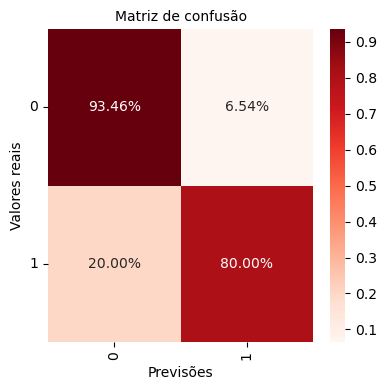

In [60]:
y_pred = mlp_1.predict(X_test_norm.values)
get_accuracy(y_test, y_pred)
get_precision(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred, True)

In [10]:
grid_1["params"].iloc[1]

"{'activation': 'relu', 'batch_size': 16, 'beta_1': 0.9, 'beta_2': 0.95, 'hidden_layer_sizes': (4, 9), 'max_iter': 300, 'n_iter_no_change': 25, 'solver': 'adam', 'verbose': False}"

In [63]:
mlp_2 = MLPClassifier(
    verbose= False,
    max_iter=300, 
    activation='relu', 
    hidden_layer_sizes=(4,9),
    batch_size=16,
    beta_1=0.9,
    beta_2=0.95,
    solver='adam',
    early_stopping=True,
    n_iter_no_change=25
)
mlp_2.fit(X_train_norm.values, y_train)

MLPClassifier(batch_size=16, beta_2=0.95, early_stopping=True,
              hidden_layer_sizes=(4, 9), max_iter=300, n_iter_no_change=25)

ACURÁCIA: 0.8827
PRECISÃO: 0.8827


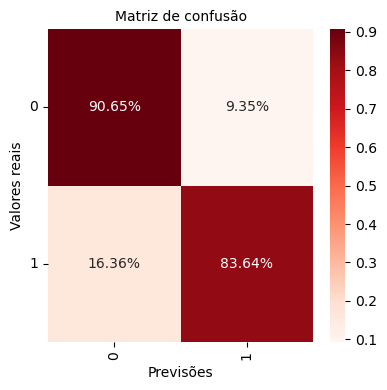

In [64]:
y_pred = mlp_2.predict(X_test_norm.values)
get_accuracy(y_test, y_pred)
get_precision(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred, True)

In [13]:
grid_1["params"].iloc[2]

"{'activation': 'logistic', 'batch_size': 16, 'beta_1': 0.9, 'beta_2': 0.9, 'hidden_layer_sizes': (6, 14), 'max_iter': 500, 'n_iter_no_change': 25, 'solver': 'adam', 'verbose': False}"

In [73]:
mlp_3 = MLPClassifier(
    verbose= False,
    max_iter=500, 
    activation='relu', 
    hidden_layer_sizes=(6,14),
    batch_size=16,
    beta_1=0.9,
    beta_2=0.9,
    solver='adam',
    early_stopping=True,
    n_iter_no_change=25
)
mlp_3.fit(X_train_norm.values, y_train)

MLPClassifier(batch_size=16, beta_2=0.9, early_stopping=True,
              hidden_layer_sizes=(6, 14), max_iter=500, n_iter_no_change=25)

ACURÁCIA: 0.9012
PRECISÃO: 0.9012


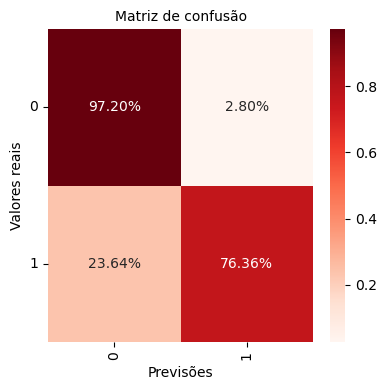

In [74]:
y_pred = mlp_3.predict(X_test_norm.values)
get_accuracy(y_test, y_pred)
get_precision(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred, True)

**Análise:** Comparando ilustrativamente, a mesma MLPClassifier tem um desempenho muito pior ao usar "logistic" (sigmoide) como função de ativação  



###  3.2 Carregando e treinando os três melhores conjuntos de hipeparâmetros da segunda busca em grade

A segunda busca em grade não considera "logistic" em sua lista de hiperparâmetros
- Paciência: $100$ e $50$
- batch_size: $16$ e $32$
- $\beta_1$: $1$, $0.9$, $0.8$, $0.95$
- $\beta_2$: $0.999$, $0.95$, $0.9$
- Épocas: $500$ e $700$
- Função de ativação: $relu$
- Quantidade de atributos considerados: $20$

In [16]:
grid_2["params"].iloc[0]

"{'activation': 'relu', 'batch_size': 32, 'beta_1': 0.9, 'beta_2': 0.9, 'hidden_layer_sizes': (5, 4), 'max_iter': 500, 'n_iter_no_change': 100, 'solver': 'adam', 'verbose': False}"

In [17]:
clf_1 = MLPClassifier(
    verbose= False,
    max_iter=500, 
    activation='relu', 
    hidden_layer_sizes=(5,4),
    batch_size=32,
    beta_1=0.9,
    beta_2=0.9,
    solver='adam',
    early_stopping=True,
    n_iter_no_change=100
)
clf_1.fit(X_train_norm.values, y_train)

MLPClassifier(batch_size=32, beta_2=0.9, early_stopping=True,
              hidden_layer_sizes=(5, 4), max_iter=500, n_iter_no_change=100)

ACURÁCIA: 0.9198
PRECISÃO: 0.9198


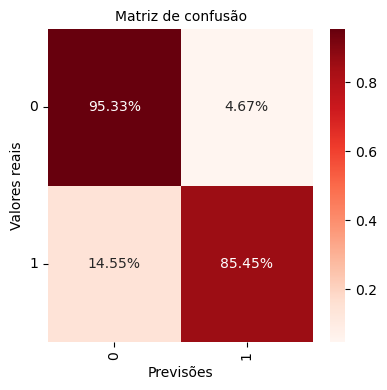

In [18]:
y_pred = clf_1.predict(X_test_norm.values)
get_accuracy(y_test, y_pred)
get_precision(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred, True)

In [19]:
grid_2["params"].iloc[1]

"{'activation': 'relu', 'batch_size': 32, 'beta_1': 0.9, 'beta_2': 0.9, 'hidden_layer_sizes': (6, 3), 'max_iter': 500, 'n_iter_no_change': 100, 'solver': 'adam', 'verbose': False}"

In [20]:
clf_2 = MLPClassifier(
    verbose= False,
    max_iter=500, 
    activation='relu', 
    hidden_layer_sizes=(6,3),
    batch_size=32,
    beta_1=0.9,
    beta_2=0.9,
    solver='adam',
    early_stopping=True,
    n_iter_no_change=100
)
clf_2.fit(X_train_norm.values, y_train)

MLPClassifier(batch_size=32, beta_2=0.9, early_stopping=True,
              hidden_layer_sizes=(6, 3), max_iter=500, n_iter_no_change=100)

ACURÁCIA: 0.8827
PRECISÃO: 0.8827


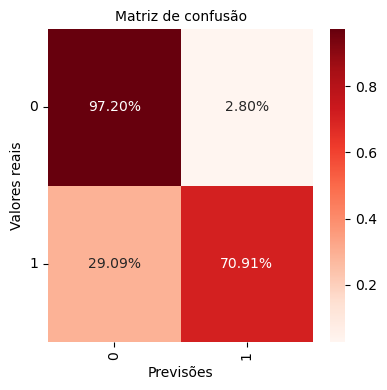

In [21]:
y_pred = clf_2.predict(X_test_norm.values)
get_accuracy(y_test, y_pred)
get_precision(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred, True)

In [22]:
grid_2["params"].iloc[2]

"{'activation': 'relu', 'batch_size': 32, 'beta_1': 0.95, 'beta_2': 0.95, 'hidden_layer_sizes': (2, 12), 'max_iter': 500, 'n_iter_no_change': 100, 'solver': 'adam', 'verbose': False}"

In [23]:
clf_3 = MLPClassifier(
    verbose= False,
    max_iter=500, 
    activation='relu', 
    hidden_layer_sizes=(2, 12),
    batch_size=32,
    beta_1=0.95,
    beta_2=0.95,
    solver='adam',
    early_stopping=True,
    n_iter_no_change=100
)
clf_3.fit(X_train_norm.values, y_train)

MLPClassifier(batch_size=32, beta_1=0.95, beta_2=0.95, early_stopping=True,
              hidden_layer_sizes=(2, 12), max_iter=500, n_iter_no_change=100)

ACURÁCIA: 0.9259
PRECISÃO: 0.9259


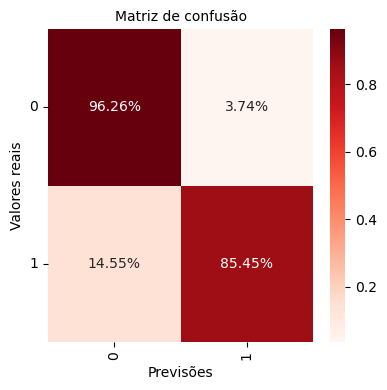

In [24]:
y_pred = clf_3.predict(X_test_norm.values)
get_accuracy(y_test, y_pred)
get_precision(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred, True)

### 3.3 Carregando e treinando os três melhores conjuntos de hipeparâmetros da terceira busca em grade

A terceira busca em grade não considera "logistic" em sua lista de hiperparâmetros e utiliza somente 15 atributos
- Paciência: $100$ e $50$
- batch_size: $16$ e $32$
- $\beta_1$: $1$, $0.9$, $0.8$ , $0.95$
- $\beta_2$: $0.999$, $0.95$, $0.9$
- Épocas: $500$ e $700$
- Função de ativação: $relu$
- Quantidade de atributos considerados: $15$

In [25]:
X_train_2 = X_train_norm.iloc[:, :15]
X_test_2 = X_test_norm.iloc[:, :15]

In [26]:
grid_3["params"].iloc[0]

"{'activation': 'relu', 'batch_size': 32, 'beta_1': 0.95, 'beta_2': 0.95, 'hidden_layer_sizes': (3, 5), 'max_iter': 700, 'n_iter_no_change': 100, 'solver': 'adam', 'verbose': False}"

In [27]:
mlp_clf_1 = MLPClassifier(
    verbose= False,
    max_iter=700, 
    activation='relu', 
    hidden_layer_sizes=(3,5),
    batch_size=32,
    beta_1=0.95,
    beta_2=0.95,
    solver='adam',
    early_stopping=True,
    n_iter_no_change=100
)
mlp_clf_1.fit(X_train_2.values, y_train)

MLPClassifier(batch_size=32, beta_1=0.95, beta_2=0.95, early_stopping=True,
              hidden_layer_sizes=(3, 5), max_iter=700, n_iter_no_change=100)

ACURÁCIA: 0.8889
PRECISÃO: 0.8889


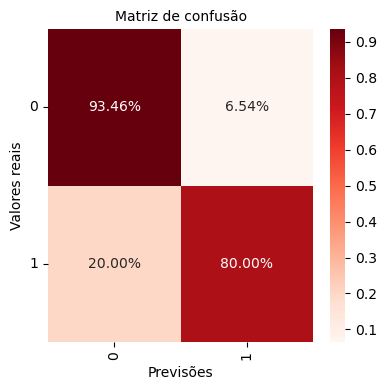

In [28]:
y_pred = mlp_clf_1.predict(X_test_2.values)
get_accuracy(y_test, y_pred)
get_precision(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred, True)

In [29]:
grid_3["params"].iloc[1]

"{'activation': 'relu', 'batch_size': 16, 'beta_1': 0.8, 'beta_2': 0.95, 'hidden_layer_sizes': (4, 8), 'max_iter': 500, 'n_iter_no_change': 50, 'solver': 'adam', 'verbose': False}"

In [30]:
mlp_clf_2 = MLPClassifier(
    verbose= False,
    max_iter=500, 
    activation='relu', 
    hidden_layer_sizes=(4,8),
    batch_size=16,
    beta_1=0.8,
    beta_2=0.95,
    solver='adam',
    early_stopping=True,
    n_iter_no_change=50
)
mlp_clf_2.fit(X_train_2.values, y_train)

MLPClassifier(batch_size=16, beta_1=0.8, beta_2=0.95, early_stopping=True,
              hidden_layer_sizes=(4, 8), max_iter=500, n_iter_no_change=50)

ACURÁCIA: 0.8272
PRECISÃO: 0.8272


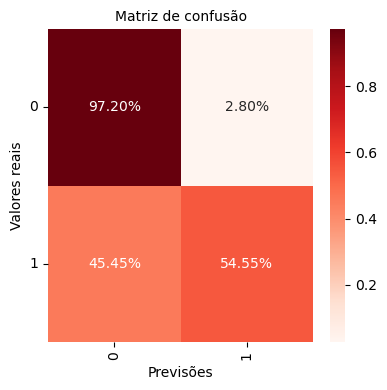

In [31]:
y_pred = mlp_clf_2.predict(X_test_2.values)
get_accuracy(y_test, y_pred)
get_precision(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred, True)

In [32]:
grid_3["params"].iloc[2]

"{'activation': 'relu', 'batch_size': 32, 'beta_1': 0.8, 'beta_2': 0.999, 'hidden_layer_sizes': (2, 10), 'max_iter': 500, 'n_iter_no_change': 50, 'solver': 'adam', 'verbose': False}"

In [33]:
mlp_clf_3 = MLPClassifier(
    verbose= False,
    max_iter=500, 
    activation='relu', 
    hidden_layer_sizes=(2,10),
    batch_size=32,
    beta_1=0.8,
    beta_2=0.999,
    solver='adam',
    early_stopping=True,
    n_iter_no_change=50
)
mlp_clf_3.fit(X_train_2.values, y_train)

MLPClassifier(batch_size=32, beta_1=0.8, early_stopping=True,
              hidden_layer_sizes=(2, 10), max_iter=500, n_iter_no_change=50)

ACURÁCIA: 0.8765
PRECISÃO: 0.8765


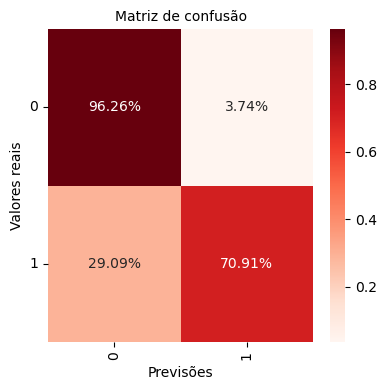

In [34]:
y_pred = mlp_clf_3.predict(X_test_2.values)
get_accuracy(y_test, y_pred)
get_precision(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred, True)

## 4. Validação cruzada

### 4.1 Validação cruzada da melhor MLP com 20 atributos preditores

In [52]:
kf = KFold(n_splits=10, shuffle=True)

best_mlp = clf_1
best_mlp.fit(X_train_norm.values, y_train)
y_pred_best = best_mlp.predict(X_test_norm.values)

In [53]:
result  = cross_validate(best_mlp, X.values, y, cv = kf, scoring=['accuracy', 'precision_micro', 'recall_micro'])

In [54]:
acc = result['test_accuracy'].mean()
prec = result['test_precision_micro'].mean()
rec = result['test_recall_micro'].mean()
result["test_accuracy"], result["test_precision_micro"]

(array([0.88888889, 0.87037037, 0.68518519, 0.88888889, 0.92592593,
        0.92592593, 0.88888889, 0.90740741, 0.86792453, 0.9245283 ]),
 array([0.88888889, 0.87037037, 0.68518519, 0.88888889, 0.92592593,
        0.92592593, 0.88888889, 0.90740741, 0.86792453, 0.9245283 ]))

In [55]:
print("----- K-FOLD SCORE --------")
print(f"Acurácia: {acc:.4f}")
print(f"Precisão: {prec:.4f}")
print()
print("---- MELHOR RNA MLP -----")
get_accuracy(y_test, y_pred_best)
get_precision(y_test, y_pred_best)

----- K-FOLD SCORE --------
Acurácia: 0.8774
Precisão: 0.8774

---- MELHOR RNA MLP -----
ACURÁCIA: 0.9198
PRECISÃO: 0.9198


0.9197530864197531

**Análise:** A melhor MLP se mostrou estável mesmo treinando com outras partes do dataset

### 4.2 Validação cruzada da melhor MLP com 15 atributos preditores

In [39]:
best_mlp = mlp_clf_2
best_mlp.fit(X_train_norm.values, y_train)
y_pred_best = best_mlp.predict(X_test_norm.values)

In [40]:
result  = cross_validate(mlp_clf_1, X.iloc[:, :15].values, y, cv = kf, scoring=['accuracy', 'precision_micro', 'recall_micro'])
acc = result['test_accuracy'].mean()
prec = result['test_precision_micro'].mean()
rec = result['test_recall_micro'].mean()
result["test_accuracy"], result["test_precision_micro"]

(array([0.92592593, 0.83333333, 0.92592593, 0.83333333, 0.92592593,
        0.90740741, 0.81481481, 0.88888889, 0.94339623, 0.83018868]),
 array([0.92592593, 0.83333333, 0.92592593, 0.83333333, 0.92592593,
        0.90740741, 0.81481481, 0.88888889, 0.94339623, 0.83018868]))

In [41]:
print("----- K-FOLD SCORE --------")
print(f"Acurácia: {acc:.4f}")
print(f"Precisão: {prec:.4f}")
print()
print("---- MELHOR RNA MLP -----")
get_accuracy(y_test, y_pred_best)
get_precision(y_test, y_pred_best)

----- K-FOLD SCORE --------
Acurácia: 0.8829
Precisão: 0.8829

---- MELHOR RNA MLP -----
ACURÁCIA: 0.9012
PRECISÃO: 0.9012


0.9012345679012346

## 5. Salvando a melhor MLP com 20 atributos preditores

In [56]:
best_mlp = clf_3

ACURÁCIA: 0.9164
PRECISÃO: 0.9164


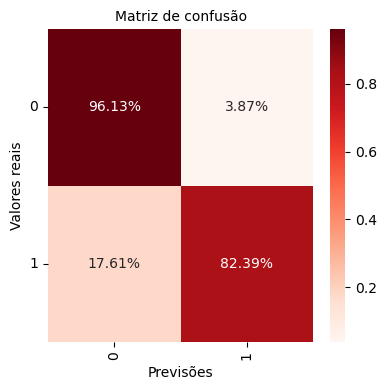

In [57]:
clf = best_mlp.fit(X.values, y)

y_pred = clf.predict(X.values)
get_accuracy(y, y_pred)
get_precision(y, y_pred)
plot_confusion_matrix(y, y_pred, True)

In [44]:
#dump(clf, 'models/pcos-diagnosis-20-params.joblib')

['models/pcos-diagnosis-20-params.joblib']

## 6. Salvando a melhor MLP com 15 atributos preditores

ACURÁCIA: 0.8848
PRECISÃO: 0.8848


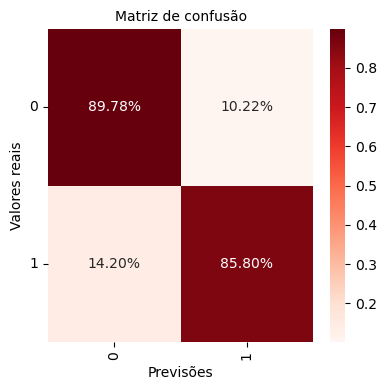

In [45]:
clf_2 = mlp_clf_2.fit(X.iloc[:, :15].values, y)

y_pred = clf_2.predict(X.iloc[:, :15].values)
get_accuracy(y, y_pred)
get_precision(y, y_pred)
plot_confusion_matrix(y, y_pred, True)

In [46]:
#dump(clf_2, 'models/pcos-diagnosis-15-params.joblib')